## Active Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sbi
sbi.__version__

'0.18.0'

In [3]:
import torch
from torch import ones, zeros, eye

from sbi.inference import SNLE, SNPE
from sbi.utils import BoxUniform
from sbi.utils.torchutils import atleast_2d
from sbi.analysis import pairplot
from sbi.inference import MCMCPosterior, RejectionPosterior, VIPosterior
from sbi.utils import mcmc_transform
from sbi.inference.potentials.base_potential import BasePotential

from copy import deepcopy

import matplotlib.pyplot as plt

from loss_calibration.loss import StepLoss_weighted, SigmoidLoss_weighted

Prior and Simulator

In [4]:
prior =BoxUniform([-1], [1])
def sim(theta):
    return theta + torch.randn(theta.shape) * 0.2

Define a potential

In [5]:
class AcquisitionPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, device="cpu"):
        super().__init__(prior, x_o, device=device)
    
    def __call__(self, theta, track_gradients=True):
        with torch.set_grad_enabled(track_gradients):
            return torch.log(acquisition_fn(theta))


Define a cost function and an acquisition function

In [6]:
#cost_fn = StepLoss_weighted([2,1], 0.)    # ! torch.gt breaks backward pass of gradients
cost_fn = SigmoidLoss_weighted([2,1], 0.)

In [7]:
num_monte_carlo_samples_likelihood = 20
num_monte_carlo_samples_posterior = 1

In [8]:
# cost/acquisition fun without batches

# def cost_fn(true_theta, sampled_theta):
#     costs = []
#     for s in sampled_theta:
#         if true_theta[0, 0] < 0.0:
#             if s[0] < 0.0:
#                 costs.append(torch.tensor([0.01]))
#             else:
#                 costs.append(torch.tensor([1.0]))
#         else:
#             if s[0] > 0.0:
#                 costs.append(torch.tensor([0.01]))
#             else:
#                 costs.append(torch.tensor([1.0]))
#     return torch.cat(costs)

# def acquisition_fn(theta_0):
#         predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0)[0] 
#         predicted_theta_given_x = []
#         for px in predicted_x: #lässt sich der loop eliminieren?
#             predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px.unsqueeze(0))[0])
#         predicted_theta_given_x = torch.cat(predicted_theta_given_x)
#         predicted_decision = (predicted_theta_given_x > 0.).float()
#         estimated_cost = cost_fn(theta_0[:,0], predicted_decision[:,0])
#         #estimated_cost = cost_fn(theta_0, predicted_theta_given_x)
#         return estimated_cost.mean()

In [9]:
def acquisition_fn(theta_0):
    theta_0 = atleast_2d(theta_0)
    # 1.sample from likelihood
    predicted_x = likelihood_estimator.sample(num_monte_carlo_samples_likelihood, context=theta_0) 
    predicted_theta_given_x = []
    # 2. for each sampled x, sample from the posterior
    for px in predicted_x.swapaxes(0,1):
        predicted_theta_given_x.append(posterior_estimator.sample(num_monte_carlo_samples_posterior, context=px))
    predicted_theta_given_x = torch.cat(predicted_theta_given_x, dim=1) 
    # 3. calculate associated cost
    predicted_decision = (predicted_theta_given_x > 0.).float()
    decisiom_dim=0
    estimated_cost = cost_fn(theta_0[:,decisiom_dim].unsqueeze(1).repeat(1,num_monte_carlo_samples_likelihood), predicted_decision[:,:,decisiom_dim])
    return estimated_cost.mean(dim=1)

In [10]:
n_rounds = 10
proposal = prior

# inference objects
inference_likelihood = SNLE(prior)
inference_posterior = SNPE(prior)

proposals = []
likelihood_estimators = []
posterior_estimators = []

for r in range(n_rounds): # rounds
    print(f'\n----- ROUND {r} -----')
    theta = proposal.sample((1000,))
    x = sim(theta)
    # train both SNLE and SNPE
    likelihood_estimator = inference_likelihood.append_simulations(theta, x).train(max_num_epochs=100)
    print('\n')
    posterior_estimator = inference_posterior.append_simulations(theta, x, proposal=proposal).train(max_num_epochs=100)

    potential = AcquisitionPotential(prior, x_o=zeros(1, 2), device="cpu")
    #prior_tf = mcmc_transform(prior)
    #acquisition_sampler = VIPosterior(potential_fn=potential, prior=prior, q='maf', theta_transform= mcmc_transform(prior), vi_method='fKL').train()
    #acquisition_sampler = MCMCPosterior(potential_fn=potential, theta_transform=prior_tf, proposal=prior, init_strategy="proposal", method="slice_np_vectorized", num_chains=100)
    acquisition_sampler = RejectionPosterior(potential_fn=potential, proposal=prior)
    proposal = acquisition_sampler

    likelihood_estimators.append(deepcopy(likelihood_estimator))
    posterior_estimators.append(deepcopy(posterior_estimator))
    proposals.append(deepcopy(proposal))


----- ROUND 0 -----


/Users/mgorecki/Documents/Studium/Master/5.Semester/Masterarbeit/sbi_v0_18_0/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 33 epochs.

 Neural network successfully converged after 60 epochs.
----- ROUND 1 -----


Drawing 1000 posterior samples: 1039it [00:06, 162.44it/s]                         


 Neural network successfully converged after 50 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 28 epochs.
----- ROUND 2 -----


Drawing 1000 posterior samples: 1046it [00:05, 198.11it/s]                         


 Neural network successfully converged after 24 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 38 epochs.
----- ROUND 3 -----


Drawing 1000 posterior samples: 1127it [00:04, 250.22it/s]                         


 Neural network successfully converged after 45 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 40 epochs.
----- ROUND 4 -----


Drawing 1000 posterior samples: 1087it [00:03, 286.47it/s]                         


 Neural network successfully converged after 85 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.
----- ROUND 5 -----


Drawing 1000 posterior samples: 1022it [00:04, 231.51it/s]                        


 Neural network successfully converged after 33 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 35 epochs.
----- ROUND 6 -----


Drawing 1000 posterior samples: 1035it [00:11, 90.60it/s]                         


 Neural network successfully converged after 21 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.
----- ROUND 7 -----


Drawing 1000 posterior samples: 1078it [00:04, 235.27it/s]                        


 Neural network successfully converged after 24 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 27 epochs.
----- ROUND 8 -----


Drawing 1000 posterior samples: 1051it [00:06, 156.59it/s]                        


 Neural network successfully converged after 50 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.
----- ROUND 9 -----


Drawing 1000 posterior samples: 1013it [00:05, 195.72it/s]                         


 Neural network successfully converged after 27 epochs.

Using SNPE-C with atomic loss
 Neural network successfully converged after 37 epochs.

In [11]:
n_samples_proposal = 1000
samples_proposal = proposal.sample((n_samples_proposal,))
samples_prior = prior.sample((10,))

Drawing 1000 posterior samples: 1030it [00:04, 245.56it/s]                        


In [12]:
thetas_linspace = torch.linspace(-1,1,500)
n_potential = 50
potential_thetas_linspace = torch.cat([torch.stack([potential(th) for th in thetas_linspace], dim=1) for r in range(n_potential)])

In [13]:
single_potential_thetas_linspace = torch.cat([potential(th) for th in thetas_linspace])
single_potential_thetas_linspace.shape

torch.Size([500])

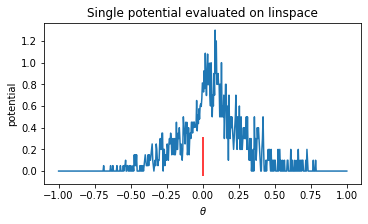

In [14]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.plot(thetas_linspace.numpy(), single_potential_thetas_linspace.exp().numpy())
ax.vlines(0.0, ymin=-0.05, ymax=max(single_potential_thetas_linspace)+0.05, color='r')
ax.set_ylabel('potential')
ax.set_xlabel(r'$\theta$')
ax.set_title("Single potential evaluated on linspace")
fig.savefig("./results/active_learning/toy_example_single_potential.jpg")

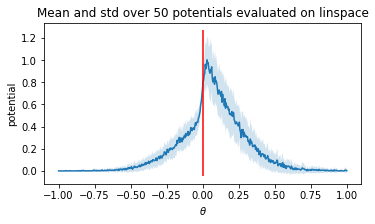

In [15]:
mean_potential = potential_thetas_linspace.exp().mean(dim=0)
std_potential = potential_thetas_linspace.exp().std(dim=0)

fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.plot(thetas_linspace, mean_potential)
ax.fill_between(thetas_linspace.numpy(), (mean_potential-std_potential).numpy(), (mean_potential+std_potential).numpy(), alpha=0.2)
ax.vlines(0.0, ymin=-0.05, ymax=max(mean_potential+std_potential)+0.05, color='r')
ax.set_ylabel('potential')
ax.set_xlabel(r'$\theta$')
ax.set_title(f"Mean and std over {n_potential} potentials evaluated on linspace")
fig.savefig("./results/active_learning/toy_example_potential.jpg")

In [16]:
potentials_samples_proposal = [potential(s).exp().item()  for s in samples_proposal]

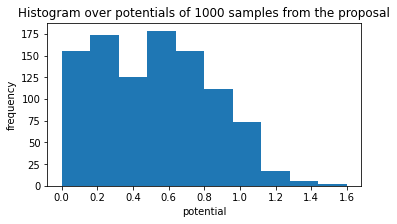

In [17]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.hist(potentials_samples_proposal)
ax.set_xlabel('potential')
ax.set_ylabel('frequency')
ax.set_title(f"Histogram over potentials of {n_samples_proposal} samples from the proposal")
fig.savefig("./results/active_learning/toy_example_potential_histogram.jpg")
plt.show()


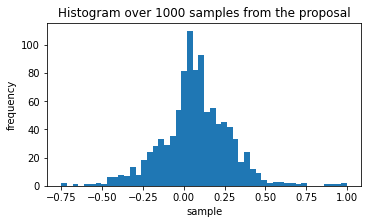

In [18]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.hist(torch.round(samples_proposal, decimals=2).numpy(), bins=50)
ax.set_xlabel('sample')
ax.set_ylabel('frequency')
ax.set_title(f"Histogram over {n_samples_proposal} samples from the proposal")
fig.savefig("./results/active_learning/toy_example_potential_samples_proposal.jpg")
plt.show()

Text(0, 0.5, 'potential')

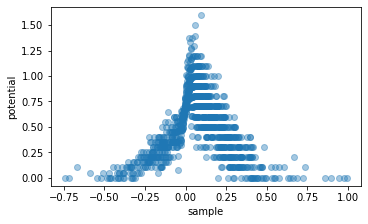

In [19]:
fig, ax = plt.subplots(1,1, figsize = (5,3), constrained_layout=True)
ax.scatter(samples_proposal, potentials_samples_proposal, alpha=0.4)
ax.set_xlabel('sample')
ax.set_ylabel('potential')